<a href="https://colab.research.google.com/github/Archi-Ahsan/CNN_LAB/blob/main/210151_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!rm -rf CNN_LAB
!git clone https://github.com/Archi-Ahsan/CNN_LAB.git
!ls -la CNN_LAB


Cloning into 'CNN_LAB'...
remote: Enumerating objects: 3268, done.
remote: Total 3268 (delta 0), reused 0 (delta 0), pack-reused 3268 (from 2)
Receiving objects: 100% (3268/3268), 53.58 MiB | 20.05 MiB/s, done.
total 24
drwxr-xr-x 5 root root 4096 Dec 25 18:06 .
drwxr-xr-x 1 root root 4096 Dec 25 18:06 ..
drwxr-xr-x 2 root root 4096 Dec 25 18:06 custom_data
drwxr-xr-x 5 root root 4096 Dec 25 18:06 dataset
drwxr-xr-x 8 root root 4096 Dec 25 18:06 .git
-rw-r--r-- 1 root root   24 Dec 25 18:06 README.md


In [2]:
!pip -q install scikit-learn

import os, random, glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [3]:
SEED = 7
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [4]:
ROOT = "/content/CNN_LAB"
DATA_DIR = os.path.join(ROOT, "dataset")
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR  = os.path.join(DATA_DIR, "test")

CUSTOM_DIR = os.path.join(ROOT, "custom_data")

print("TRAIN:", TRAIN_DIR)
print("TEST :", TEST_DIR)
print("CUSTOM:", CUSTOM_DIR)

print("Custom images:", len(glob.glob(os.path.join(CUSTOM_DIR, "*.*"))))


TRAIN: /content/CNN_LAB/dataset/train
TEST : /content/CNN_LAB/dataset/test
CUSTOM: /content/CNN_LAB/custom_data
Custom images: 10


In [5]:
IMG_EXTS = (".jpg", ".jpeg", ".png", ".bmp", ".webp")

def folder_classes(root_dir):
    return sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])

train_folders = folder_classes(TRAIN_DIR)
class_names = sorted(list({c.lower() for c in train_folders}))  # canonical lowercase
label_id = {c:i for i,c in enumerate(class_names)}
id_label = {i:c for c,i in label_id.items()}

print("Classes:", class_names)
print("Num classes:", len(class_names))


Classes: ['apple', 'avocado', 'banana', 'cherry', 'kiwi', 'mango', 'orange', 'pinenapple', 'strawberries', 'watermelon']
Num classes: 10


In [6]:
def scan_images(root_dir, label_id):
    records = []
    for folder in os.listdir(root_dir):
        fpath = os.path.join(root_dir, folder)
        if not os.path.isdir(fpath):
            continue

        key = folder.lower()
        if key not in label_id:
            continue

        y = label_id[key]
        for fn in os.listdir(fpath):
            if fn.lower().endswith(IMG_EXTS):
                records.append((os.path.join(fpath, fn), y))
    return records

all_train = scan_images(TRAIN_DIR, label_id)
all_test  = scan_images(TEST_DIR,  label_id)

print("Train images:", len(all_train))
print("Test images :", len(all_test))


Train images: 2301
Test images : 922


In [8]:
IMG_SIZE = 128
MEAN = [0.485, 0.456, 0.406]
STD  = [0.229, 0.224, 0.225]

train_tf = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.75, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(8),
    transforms.ColorJitter(brightness=0.10, contrast=0.10, saturation=0.10),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

test_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])


In [9]:
class FruitRecords(Dataset):
    def __init__(self, records, transform=None):
        self.records = records
        self.transform = transform

    def __len__(self):
        return len(self.records)

    def __getitem__(self, idx):
        path, y = self.records[idx]
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, y, path


In [10]:
rng = np.random.default_rng(SEED)
idx = np.arange(len(all_train))
rng.shuffle(idx)

val_count = int(0.15 * len(all_train))
val_idx = idx[:val_count]
tr_idx  = idx[val_count:]

train_set = FruitRecords([all_train[i] for i in tr_idx], transform=train_tf)
val_set   = FruitRecords([all_train[i] for i in val_idx], transform=test_tf)
test_set  = FruitRecords(all_test, transform=test_tf)

print("Train:", len(train_set), "Val:", len(val_set), "Test:", len(test_set))


Train: 1956 Val: 345 Test: 922


In [11]:
BATCH = 32

train_loader = DataLoader(train_set, batch_size=BATCH, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_set,   batch_size=BATCH, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_set,  batch_size=BATCH, shuffle=False, num_workers=2)


In [12]:
class FruitNet(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 96, 3, padding=1), nn.BatchNorm2d(96), nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(96, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
        )
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.30),
            nn.Linear(128, n_classes)
        )

    def forward(self, x):
        x = self.block(x)
        x = self.gap(x)
        return self.head(x)

model = FruitNet(len(class_names)).to(device)
model


FruitNet(
  (block): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1

In [15]:
EPOCHS = 20
LR = 1e-3

loss_fn = nn.CrossEntropyLoss(label_smoothing=0.03)
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=2e-4)

# StepLR: drops LR every 6 epochs (simple + stable)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.5)


In [16]:
def one_pass(loader, train=True):
    model.train() if train else model.eval()

    total_loss = 0.0
    total_ok = 0
    total_n = 0

    for x, y, _ in loader:
        x, y = x.to(device), y.to(device)

        if train:
            optimizer.zero_grad()

        with torch.set_grad_enabled(train):
            logits = model(x)
            loss = loss_fn(logits, y)

            if train:
                loss.backward()
                optimizer.step()

        total_loss += loss.item() * x.size(0)
        pred = logits.argmax(1)
        total_ok += (pred == y).sum().item()
        total_n += y.size(0)

    return total_loss/total_n, 100.0*total_ok/total_n


train_loss_hist, train_acc_hist = [], []
val_loss_hist, val_acc_hist = [], []

best_val = -1
best_weights = None

for ep in range(1, EPOCHS+1):
    trL, trA = one_pass(train_loader, train=True)
    vaL, vaA = one_pass(val_loader, train=False)

    scheduler.step()

    train_loss_hist.append(trL); train_acc_hist.append(trA)
    val_loss_hist.append(vaL);   val_acc_hist.append(vaA)

    if vaA > best_val:
        best_val = vaA
        best_weights = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

    print(f"Epoch {ep:02d}/{EPOCHS} | Train: {trL:.3f}, {trA:.2f}% | Val: {vaL:.3f}, {vaA:.2f}% | LR={optimizer.param_groups[0]['lr']:.6f}")

# load best
model.load_state_dict(best_weights)
model.to(device)
print("Best Val Acc:", best_val)


Epoch 01/20 | Train: 1.140, 65.13% | Val: 1.235, 61.45% | LR=0.001000
Epoch 02/20 | Train: 1.139, 64.57% | Val: 1.210, 62.03% | LR=0.001000
Epoch 03/20 | Train: 1.085, 67.54% | Val: 1.522, 56.81% | LR=0.001000
Epoch 04/20 | Train: 1.044, 68.10% | Val: 1.168, 61.16% | LR=0.001000
Epoch 05/20 | Train: 1.060, 66.97% | Val: 1.091, 68.70% | LR=0.001000
Epoch 06/20 | Train: 1.040, 68.61% | Val: 1.335, 60.29% | LR=0.000500
Epoch 07/20 | Train: 0.998, 69.33% | Val: 1.036, 68.41% | LR=0.000500
Epoch 08/20 | Train: 0.954, 71.63% | Val: 1.042, 67.83% | LR=0.000500
Epoch 09/20 | Train: 0.971, 71.22% | Val: 0.989, 70.43% | LR=0.000500
Epoch 10/20 | Train: 0.909, 73.72% | Val: 1.097, 65.80% | LR=0.000500
Epoch 11/20 | Train: 0.950, 70.91% | Val: 1.047, 69.57% | LR=0.000500
Epoch 12/20 | Train: 0.908, 73.77% | Val: 0.996, 69.28% | LR=0.000250
Epoch 13/20 | Train: 0.862, 75.61% | Val: 0.917, 73.04% | LR=0.000250
Epoch 14/20 | Train: 0.871, 74.74% | Val: 0.935, 73.62% | LR=0.000250
Epoch 15/20 | Train:

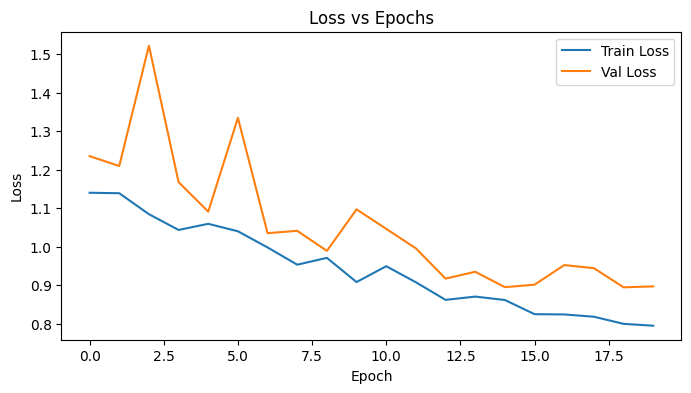

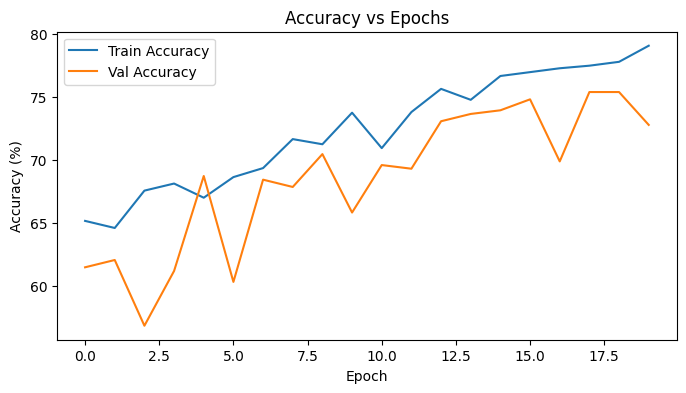

In [17]:
plt.figure(figsize=(8,4))
plt.plot(train_loss_hist, label="Train Loss")
plt.plot(val_loss_hist, label="Val Loss")
plt.title("Loss vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,4))
plt.plot(train_acc_hist, label="Train Accuracy")
plt.plot(val_acc_hist, label="Val Accuracy")
plt.title("Accuracy vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()


TEST Accuracy: 72.67%


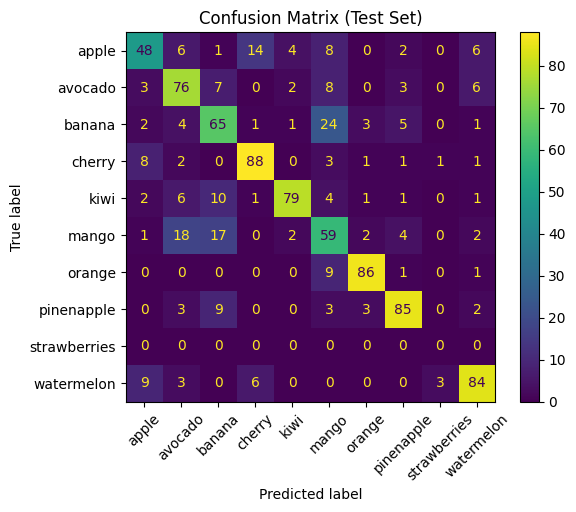

In [19]:
model.eval()
pred_all, true_all = [], []

with torch.no_grad():
    for x, y, _ in test_loader:
        out = model(x.to(device))
        pred = out.argmax(1).cpu().numpy()
        pred_all.extend(pred)
        true_all.extend(y.numpy())

pred_all = np.array(pred_all)
true_all = np.array(true_all)

acc_test = 100.0 * (pred_all == true_all).mean()
print(f"TEST Accuracy: {acc_test:.2f}%")

cm = confusion_matrix(true_all, pred_all)
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
disp.plot(xticks_rotation=45, values_format="d", )
plt.title("Confusion Matrix (Test Set)")
plt.show()


Collected: 10 correct, 3 incorrect


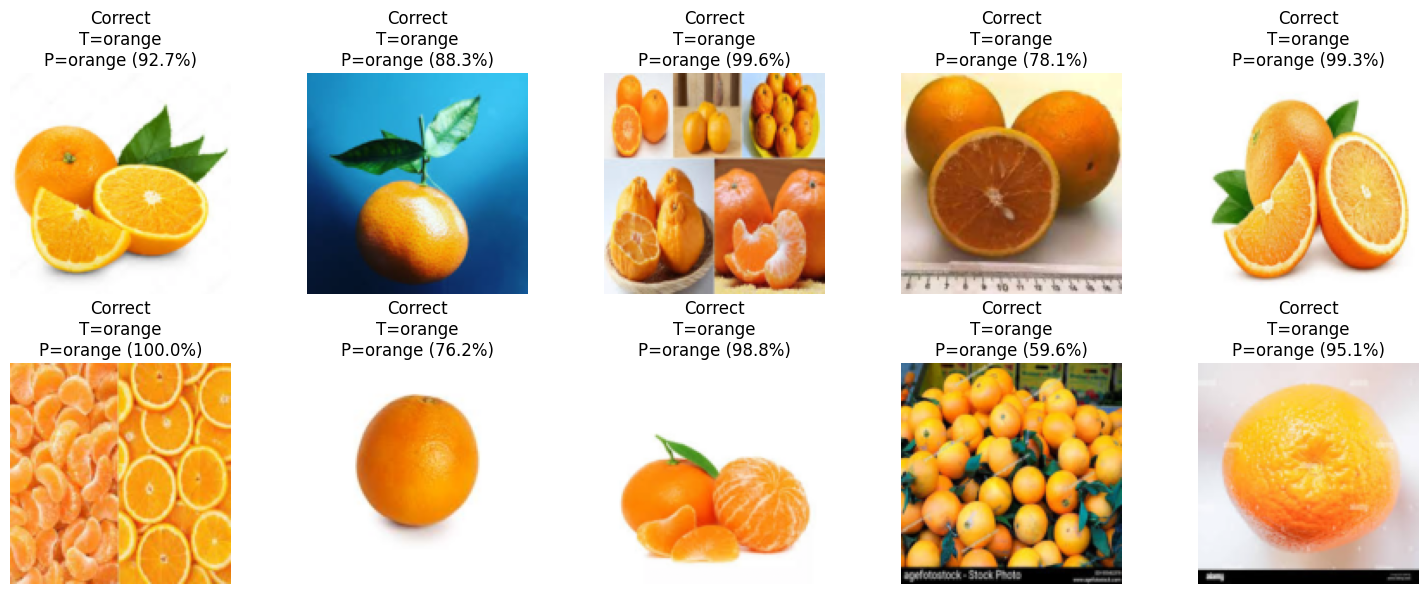

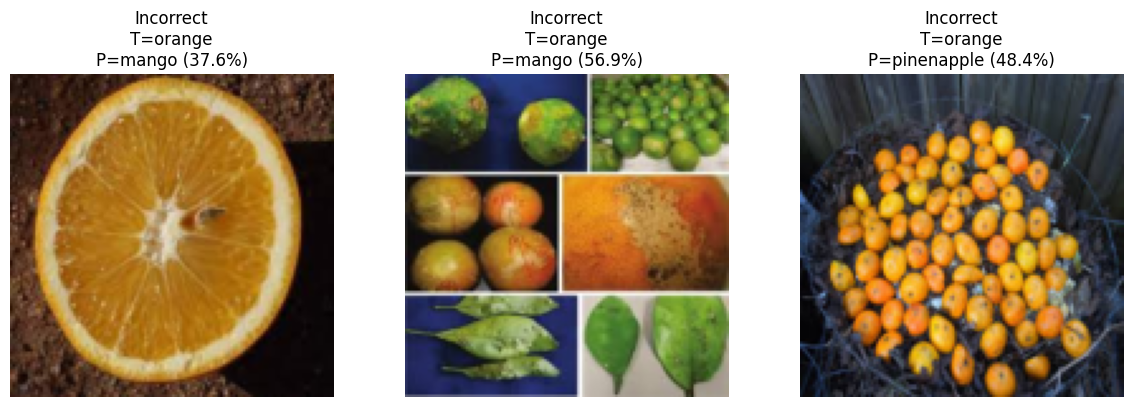

In [20]:
def unnorm(img_t):
    img = img_t.clone()
    for c in range(3):
        img[c] = img[c] * STD[c] + MEAN[c]
    return torch.clamp(img, 0, 1)

def show_img(t):
    t = unnorm(t)
    plt.imshow(t.permute(1,2,0).numpy())
    plt.axis("off")

correct, wrong = [], []

model.eval()
with torch.no_grad():
    for x, y, paths in test_loader:
        out = model(x.to(device))
        prob = torch.softmax(out, dim=1).cpu()
        pred = prob.argmax(1)

        for i in range(x.size(0)):
            t = int(y[i])
            p = int(pred[i])
            cf = float(prob[i, p])

            if t == p and len(correct) < 10:
                correct.append((x[i].cpu(), t, p, cf))
            if t != p and len(wrong) < 3:
                wrong.append((x[i].cpu(), t, p, cf))

            if len(correct) >= 10 and len(wrong) >= 3:
                break
        if len(correct) >= 10 and len(wrong) >= 3:
            break

print(f"Collected: {len(correct)} correct, {len(wrong)} incorrect")

plt.figure(figsize=(15,6))
for k, (img, t, p, cf) in enumerate(correct):
    plt.subplot(2,5,k+1)
    show_img(img)
    plt.title(f"Correct\nT={id_label[t]}\nP={id_label[p]} ({cf*100:.1f}%)")
plt.tight_layout()
plt.show()


plt.figure(figsize=(12,4))
for k, (img, t, p, cf) in enumerate(wrong):
    plt.subplot(1,3,k+1)
    show_img(img)
    plt.title(f"Incorrect\nT={id_label[t]}\nP={id_label[p]} ({cf*100:.1f}%)")
plt.tight_layout()
plt.show()


Custom files: ['apple.jpg', 'avocado.jpg', 'banana.jpg', 'cherry.jpg', 'kiwi.jpg', 'mango.jpg', 'orange.jpg', 'pineapple.jpg', 'strawberry.jpg', 'watermelon.jpg']


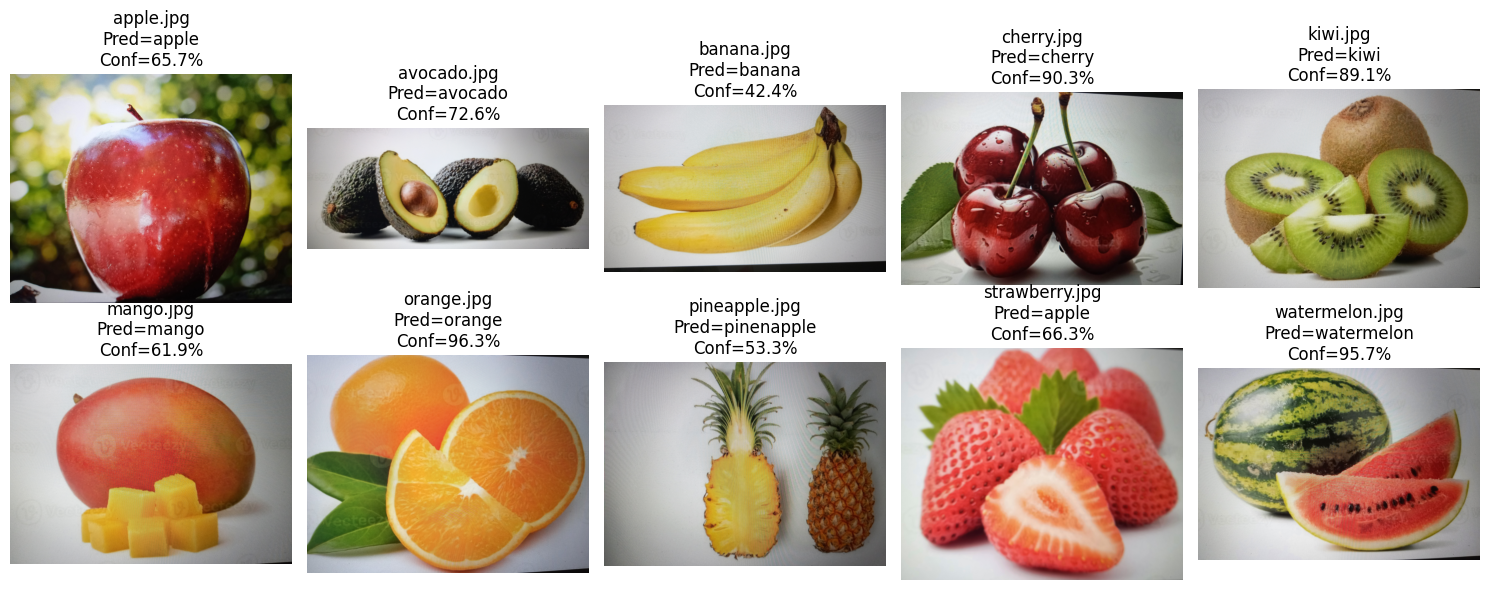

In [21]:
custom_files = sorted([f for f in glob.glob(os.path.join(CUSTOM_DIR, "*"))
                       if f.lower().endswith(IMG_EXTS)])[:10]

print("Custom files:", [os.path.basename(x) for x in custom_files])

plt.figure(figsize=(15,6))
model.eval()

for i, f in enumerate(custom_files):
    img = Image.open(f).convert("RGB")
    x = test_tf(img).unsqueeze(0).to(device)

    with torch.no_grad():
        out = model(x)
        pr = torch.softmax(out, dim=1)[0].cpu().numpy()
        p = int(np.argmax(pr))
        conf = float(pr[p])

    plt.subplot(2,5,i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"{os.path.basename(f)}\nPred={id_label[p]}\nConf={conf*100:.1f}%")

plt.tight_layout()
plt.show()


In [22]:
STUDENT_ID = "ARCHI_AHSAN"
SAVE_DIR = os.path.join(ROOT, "model")
os.makedirs(SAVE_DIR, exist_ok=True)

save_path = os.path.join(SAVE_DIR, f"{STUDENT_ID}.pth")
torch.save(model.state_dict(), save_path)
print("Saved:", save_path)

# reload check
tmp = FruitNet(len(class_names)).to(device)
tmp.load_state_dict(torch.load(save_path, map_location=device))
tmp.eval()
print("Reload OK ✅")


Saved: /content/CNN_LAB/model/ARCHI_AHSAN.pth
Reload OK ✅
